# Chapitre 2: Classification

<function matplotlib.pyplot.show(close=None, block=None)>

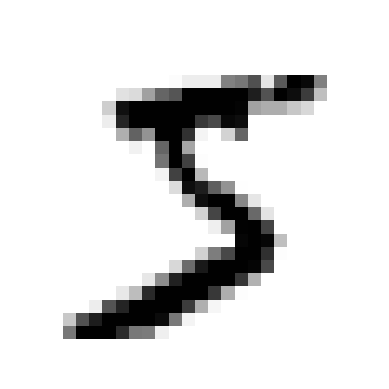

In [2]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

def load_data():
    return fetch_openml("mnist_784", as_frame=False)

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")


mnist = load_data()
X, y = mnist.data, mnist.target # X hold the data of each entry and y its label
plot_digit(X[0])
plt.show


Now we need to look to create a test and a training set out of our data. Luckily the data is already splitted (60.000 training rows and 10.000 testing entries)

In [3]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60_000], y[60_000:]

## Binary classifier to detect a single digit (5)

A binary classifier is an prediction algorithm that is only capable of distinguishing between two values(in our case it can only answer if the number provided is 5 or not). For this task scikit-learn provide for us the SGDClassifier class (SGD for Schotastic Gradient Descent). This classifier guesses if the image(s) provided represent 5 or not and return and array of boolean.

In [4]:
y_train_5 = (y_train == "5")
y_test_5 = (y_test == '5')
# Now lets use a schotastic gradient descent to train our model
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# Let's verify the accuracy of it
sgd_clf.predict([X[0]])

array([ True])

## Measuring the performance of our model

Measuring the performance of a classifier is more challenging than measuring the performance of a regression model(like the one the previous chapter). But
first let us start by using the same one (the k-fold cross-validation with 3 fold).  
__Side Note__: A k-fold cross validation is an algorithm that divide the training set into k subsets, train the model on k times and hold one randomly each
time for evaluation.


In [5]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

If we print the accuracy of the model we will get a pretty high number, but as demonstrated by the following block this evaluation is fondamentally flawed.

In [6]:
from sklearn.dummy import DummyClassifier
# A dummy classifier always predict the given entry as the most frequent value in the dataset (in our case it always says that the given image is not a 5)
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict([X[0]])))

cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

False


array([0.90965, 0.90965, 0.90965])

This is because the cross validation looks at the general prediction score of it, therefore it is problematic(10% of the images are 5s, so if you always
guess that an image is not a 5,you will be right about 90% of the time). 

__Important Side Note__: It might be useful sometime to have more control over the cross validation scoring system, so here is an implementation of that
function.

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

def cross_val_clone(n: int) -> None:
    skfolds = StratifiedKFold(n_splits=n) # Add the argument shuffled=True if we want to shuffle the dataset before splitting it.
    for train_index, test_index in skfolds.split(X_train, y_train_5):
        clone_clf = clone(sgd_clf)
        X_train_folds = X_train[train_index]
        y_train_folds = y_train_5[train_index]
        X_test_folds = X_test[test_index]
        y_test_folds = y_test_5[test_index]
        clone_clf.fit(X_train_folds, y_train_folds)

        y_pred = clone_clf.predict(X_test_folds)
        n_correct = sum(y_pred == y_test_folds)
        print(n_correct / len(y_pred))

## Evaluating using a confusion matrix

A confusion matrix is a matrix that stores the number of times a given instance A is classified as an instance B. For example if we want to know how much
time our model has mistaken the number 8 to a 0 we look at the row 8, column 0 of the matrix. Before calculating the confusion matrix, we will first set a
number of predictions to compare them with the target value(5).

In [8]:
from sklearn.model_selection import cross_val_predict

y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Now we can create the confusion matrix and pass it the target and the predictions.

In [9]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_predict)

array([[53892,   687],
       [ 1891,  3530]])

The rows are the classes (first row represents the non-5 class and the second represents the 5) and the columns represents the predicted classes (again non-5 and 5 respectively). But we might need more informative metrics so scikit-learn provides us the precision_score and the recall_score functions to
work with.

In [10]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score # The f1 score is the combination of the recall and the precision score and is given by this formula
# 2 * (precision * recall)/ (precision + recall)

precision_score(y_train_5, y_train_predict)
recall_score(y_train_5, y_train_predict)
f1_score(y_train_5, y_train_predict)

np.float64(0.7325171197343847)

The precision and recall scores are which means we can't have a high precision without decreasing significantly our recall score. TO illustrate that we
deep dive in the functionning of the _SGDClassifier_:  
For each instance it computes a score based on a _decision\_function_, if this score if lower than a threshold then it classify him as a negative, otherwise
it is classified as a positive. With scikit-learn we can access the decision scores for each instance by calling the _decision\_function()_ method on the
classifier.

In [11]:
y_scores = sgd_clf.decision_function([X[0]])
print(y_scores)
threshold = 0
# So here we used a variable and a boolean to manually set out prediction if the score of the decision function is superior than our set threshold
y_pred = (y_scores > threshold) 
print(y_pred)

[2164.22030239]
[ True]


And let's raise the threshold and observe the effect on the recall score

In [12]:
threshold = 3000
y_pred2 = (y_scores > threshold)
print(y_pred2)

[False]


To determine the best threshold for our model we can get the scores using the _cross\_val\_predict()_ function but as parameter we need to modify the
_method_ parameter to "decision_function" to get the decision scores and not the prediction scores, after that we can plot the precision and the recall
score against the possible values for the threshold.

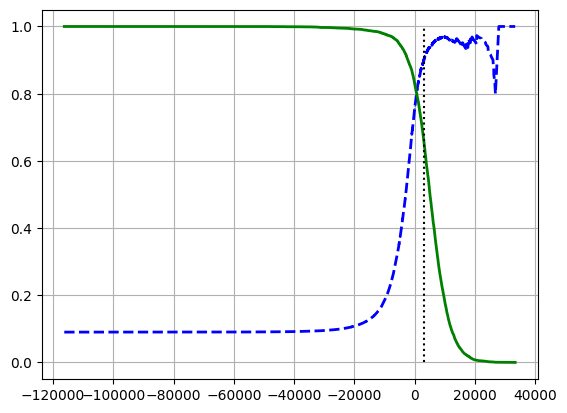

In [13]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, method="decision_function")
precision, recall, thresholds = precision_recall_curve(y_train_5, y_scores)

# Now we use maplotlib to plot the two values against the threshold
plt.plot(thresholds, precision[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recall[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.grid(True)
plt.show()

As we can see at the threshold value of 3000, the precision is at 90% and the recall at 50%. Alternatively we can plot the precision and the recall against
each other.

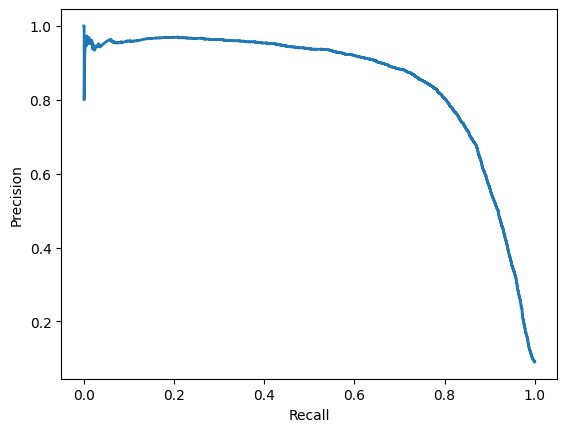

In [14]:
plt.plot(recall, precision, linewidth=2, label="Precision/Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

We can observe that the precision fall drastically at around 80% recall so we will want to select a threshold around those values most of the time. We now
assume that we want an 85% precision score. We can use the numpy's array _argmax()_ method to get the lowest threshold that gives at least 85% precision
score 

In [15]:
idx_85_precision = (precision > 0.85).argmax()
lowest_threshold = thresholds[idx_85_precision]
print(lowest_threshold)

1597.5772240265965


Another way of improving our error measurement is the ROC(receiver operating characteristic) curve. This function plot the true positive rate (the recall)
against the false positive rate(FPR).

In [16]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

And now to find the point with an 85% precision, we can look for the index of the threshold we want (since there are in decresing order).

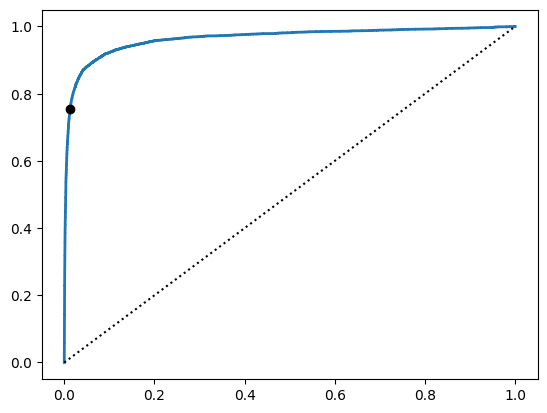

In [17]:
idx_threshold_85 = (thresholds <= lowest_threshold).argmax()
tpr_85, fpr_85 = tpr[idx_threshold_85], fpr[idx_threshold_85]

plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random Classifier ROC curve")
plt.plot([fpr_85], [tpr_85], "ko", label="Threshold for 85% precision")
plt.show()

One way we can compare the efficient of the different classifiers is to measure the area between the two curves. A perfect classifier has an area of 1.

In [18]:
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_train_5, y_scores))

0.9648211175804801


__Important Note__: We should use the precision recall curve when the positive class is rare in the dataset, otherwise we should use the roc curve.

Let's now use a use a _RandomForestClassifier_ and compare it to our sgd classifier.

In [19]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

# Now we train the model using the cross_val_predict function 
y_proba_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

print(y_proba_forest[:2]) # we print the first two instances's probabilities of being a 5.

[[0.11 0.89]
 [0.99 0.01]]


We can observe here that the model classify the first image to be positive at 89% and the second image is negative at 99%. Now let's pass this scores to
the precision recall curve.

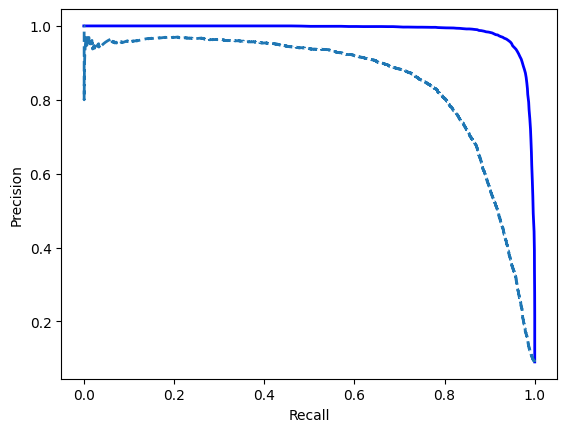

In [20]:
y_scores_forest = y_proba_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recall, precision, "--", linewidth=2, label="SGD")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

## Classifying using a multiclass classifier

This type of model can distinguish between multiple classes which means that we are going to train it to recognize all the possible digits in the dataset. 
Some of the most commonly used are the _LogisticRegression()_, _RandomForestClassifier()_ ... etc. One strategy to create a system to classify 10 digits is
to train 10 differents binary classifier one for each digit ,this is called the OVR(one versus the rest) strategy and another strategy is to train a binary
classifier for every pair of digits

In [21]:
from sklearn.svm import SVC

svc_clf = SVC(random_state=42)
svc_clf.fit(X_train[:2000], y_train[:2000])
print(svc_clf.predict([X[0]]))

['5']


To analyse the error rate of our classifier we are going to look at its confusion matrix.

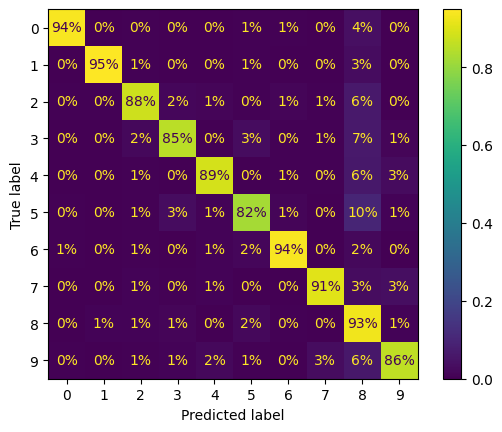

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
# Here we have just scaled the training input to get better accuracy
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3) 

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize='true', values_format=".0%")
plt.show()

## Exercice 1

We are going to use a _KNeighborsClassifier()_ to create a model with better accuracy. After that we will use a grid search to determine the best set of
hyperparameters.

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

kn_clf = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(kn_clf, param_grid, cv=3)
grid_search.fit(X_train_scaled, y_train)

print(grid_search.best_params_)

{'n_neighbors': 5, 'weights': 'distance'}


## Exercice 2

We are going to write a function that can shift a given image one pixel to the right, the left, up or down. Moreover we are going to add images shifted to
all directions to the dataset so that it get better accuracy.

In [ ]:
from scipy.ndimage import shift
import numpy as np

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image), dx, dy)
        y_train_augmented.append(label)


X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)